# Hello and welcome to Lab #1

The purpose of this lab is to introduce you to contextual bandits which are an effective tool in making product recommendations. We will be going through the framework Matt uses which is TACT.

* T: Target
* A: Arrange
* C: Compose
* T: Transmit

This lab will introduce you to how to build an effective product recommendation tool.

In [4]:
from recogym.envs.session import OrganicSessions

from numpy.random.mtrand import RandomState
from recogym import Configuration, DefaultContext, Observation
from recogym.agents import Agent
from recogym.agents import organic_user_count_args, OrganicUserEventCounterAgent
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from recogym.evaluate_agent import verify_agents, plot_verify_agents
from recogym.agents import FeatureProvider

import math
import gym
from copy import deepcopy
from recogym import env_1_args
import matplotlib.pyplot as plt
import numpy as np

# Target

What is our target we want to achieve? In this example we want to maximize CTR or Click Through Rate.

This is the percentage of how many times someone will click through to a subsequent product. The higher the percentage the higher the possibility they will buy.

# Arrange the data

We will be utilizing the recogym repository to create synthetic product recommendations. Of course in the wild you would want to utilize your own datastream from whatever service you are using.

For this test we will be trying out 1000 users across 10 products. Can we do a good job with increasing CTR?

In [5]:
NUM_USERS = 1000
NUM_PRODUCTS = 10

config = {
    **env_1_args,
    'random_seed': 42,
    'num_products': NUM_PRODUCTS
}

env = gym.make('reco-gym-v1')
env.init_gym(config)

organic_counter_agent = OrganicUserEventCounterAgent(Configuration({
   **organic_user_count_args,
   **config,
   'select_randomly': True,
}))

popularity_policy_logs = env.generate_logs(NUM_USERS, organic_counter_agent)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 1000/1000 [00:22<00:00, 44.10it/s]


In [72]:
# T is time
# u is user
# z is type
# a is action
# c is reward (click)
# ps is probability of next state
# ps-a is probability of actions
popularity_policy_logs

,t,u,z,v,a,c,ps,ps-a
0,0.0,0,organic,0,NaN,NaN,NaN,None
1,1.0,0,bandit,NaN,0,0.0,1.000000,()
2,2.0,0,bandit,NaN,0,0.0,1.000000,()
3,3.0,0,bandit,NaN,0,0.0,1.000000,()
4,4.0,0,bandit,NaN,0,0.0,1.000000,()
...,...,...,...,...,...,...,...,...
101609,96.0,999,bandit,NaN,3,0.0,0.081081,()
101610,97.0,999,bandit,NaN,0,0.0,0.135135,()
101611,98.0,999,bandit,NaN,3,0.0,0.081081,()
101612,99.0,999,bandit,NaN,9,0.0,0.648649,()


In [7]:
env.reset()
done = False

# Counting how many steps.
i = 0

observation, reward, done = None, 0, False

while not done:
    action, observation, reward, done, info = env.step_offline(observation, reward, done)
    print(f"Step: {i} - Action: {action} - Observation: {observation.sessions()} - Reward: {reward}")
    i += 1

Step: 0 - Action: None - Observation: [{'t': 0, 'u': 0, 'z': 'pageview', 'v': 8}, {'t': 1, 'u': 0, 'z': 'pageview', 'v': 3}, {'t': 2, 'u': 0, 'z': 'pageview', 'v': 4}, {'t': 3, 'u': 0, 'z': 'pageview', 'v': 9}, {'t': 4, 'u': 0, 'z': 'pageview', 'v': 4}] - Reward: None
Step: 1 - Action: {'t': 5, 'u': 0, 'a': 5, 'ps': 0.1, 'ps-a': ()} - Observation: [{'t': 6, 'u': 0, 'z': 'pageview', 'v': 9}] - Reward: 0
Step: 2 - Action: {'t': 7, 'u': 0, 'a': 1, 'ps': 0.1, 'ps-a': ()} - Observation: [] - Reward: 0
Step: 3 - Action: {'t': 8, 'u': 0, 'a': 6, 'ps': 0.1, 'ps-a': ()} - Observation: [] - Reward: 0
Step: 4 - Action: {'t': 9, 'u': 0, 'a': 3, 'ps': 0.1, 'ps-a': ()} - Observation: [] - Reward: 0
Step: 5 - Action: {'t': 10, 'u': 0, 'a': 1, 'ps': 0.1, 'ps-a': ()} - Observation: [] - Reward: 0
Step: 6 - Action: {'t': 11, 'u': 0, 'a': 4, 'ps': 0.1, 'ps-a': ()} - Observation: [] - Reward: 0
Step: 7 - Action: {'t': 12, 'u': 0, 'a': 5, 'ps': 0.1, 'ps-a': ()} - Observation: [] - Reward: 0
Step: 8 - Actio

In [8]:
def build_rectangular_data(logs, feature_provider):
    """Create a rectangular feature set from the logged data.
    For each taken action, we compute the state in which the user was when the action was taken
    """
    user_states, actions, rewards, proba_actions = [], [], [], []
    
    current_user = None
    for _, row in logs.iterrows():
        if current_user != row['u']:
            # Use has changed: start a new session and reset user state
            current_user = row['u']
            sessions = OrganicSessions()
            feature_provider.reset()
        
        context = DefaultContext(row['u'], row['t'])
        
        if row['z'] == 'organic':
            sessions.next(context, row['v'])
            
        else:
            # For each bandit event, generate one observation for the user state, the taken action
            # the obtained reward and the used probabilities
            feature_provider.observe(Observation(context, sessions))
            user_states += [feature_provider.features(None)] 
            actions += [row['a']]
            rewards += [row['c']]
            proba_actions += [row['ps']] 
            
            # Start a new organic session
            sessions = OrganicSessions()
    
    return np.array(user_states), np.array(actions).astype(int), np.array(rewards), np.array(proba_actions)

In [9]:
class ProductCountFeatureProvider(FeatureProvider):
    """This feature provider creates a user state based on viewed product count.
    Namely, the feature vector of shape (n_products, ) contains for each product how many times the
    user has viewed them organically.
    """

    def __init__(self, config):
        super(ProductCountFeatureProvider, self).__init__(config)
        self.feature_data = np.zeros((self.config.num_products)).astype(int)

    def observe(self, observation):
        for session in observation.sessions():
            self.feature_data[int(session['v'])] += 1

    def features(self, observation):
        return self.feature_data.copy()

    def reset(self):
        self.feature_data[:] = 0


def build_rectangular_data(logs, feature_provider):
    """Create a rectangular feature set from the logged data.
    For each taken action, we compute the state in which the user was when the action was taken
    """
    user_states, actions, rewards, proba_actions = [], [], [], []
    
    current_user = None
    for _, row in logs.iterrows():
        if current_user != row['u']:
            # Use has changed: start a new session and reset user state
            current_user = row['u']
            sessions = OrganicSessions()
            feature_provider.reset()
        
        context = DefaultContext(row['u'], row['t'])
        
        if row['z'] == 'organic':
            sessions.next(context, row['v'])
            
        else:
            # For each bandit event, generate one observation for the user state, the taken action
            # the obtained reward and the used probabilities
            feature_provider.observe(Observation(context, sessions))
            user_states += [feature_provider.features(None)] 
            actions += [row['a']]
            rewards += [row['c']]
            proba_actions += [row['ps']] 
            
            # Start a new organic session
            sessions = OrganicSessions()
    
    return np.array(user_states), np.array(actions).astype(int), np.array(rewards), np.array(proba_actions)

In [14]:
# You can now see data that will be provided to our agents based on logistic regressions
feature_provider = ProductCountFeatureProvider(config=Configuration(config))
user_states, actions, rewards, proba_actions = build_rectangular_data(popularity_policy_logs, feature_provider)

# Compose the model

We will go through a few iterations here:

1. RandomAgent (Pull levers at random)
2. GreedyAgent
3. Bandit
4. ContextualBandit

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 1000/1000 [00:15<00:00, 62.78it/s]


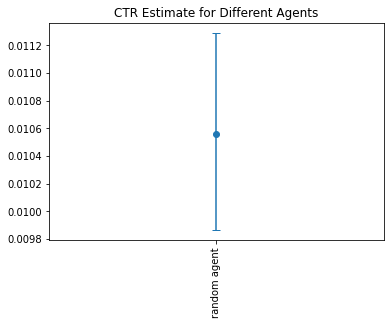

In [25]:
from recogym.agents import RandomAgent

result = verify_agents(env, NUM_USERS, {
    'random agent': RandomAgent(),
})

fig = plot_verify_agents(result)
plt.show()

# What do you notice here?

Ok so we look at this and what do you notice as the click through rate?
* High range?
* Low range?
* Good?

Honestly to get a 1% clickthrough rate by pulling random levers doesn't seem bad right?

Can we do better?

# Epsilon Greedy

Epsilon greedy will balance exploring with epsilon probability with exploiting 1-epslion of the time.

In the below example we will look at balancing based on most frequently clicked items.

We might think that this would be better. But let's find out!

In [27]:
class EpsilonGreedy(Agent):
    def __init__(self, config, agent):
        super(EpsilonGreedy, self).__init__(config)
        self.agent = agent
        self.rng = RandomState(self.config.random_seed)

    def train(self, observation, action, reward, done = False):
        self.agent.train(observation, action, reward, done)

    def act(self, observation, reward, done):
        greedy_action = self.agent.act(observation, reward, done)

        if self.rng.choice([True, False], p = [self.config.epsilon, 1.0 - self.config.epsilon]):
            if self.config.epsilon_select_worse:
                product_probas = greedy_action['ps-a']
                product_probas = (1.0 - product_probas)  # Inversion of probabilities.
            else:
                product_probas = np.ones(self.config.num_products)

            if self.config.epsilon_pure_new:
                product_probas[greedy_action['a']] = 0.0
            product_probas = product_probas / np.sum(product_probas)
            epsilon_action = self.rng.choice(
                self.config.num_products,
                p = product_probas
            )
            return {
                **super().act(observation, reward, done),
                **{
                    'a': epsilon_action,
                    'ps': self.config.epsilon * product_probas[epsilon_action],
                    'ps-a': (
                            self.config.epsilon * product_probas
                            if self.config.with_ps_all else
                            ()
                    ),
                    'greedy': False,
                    'h0': greedy_action['a']
                }
            }
        else:
            return {
                **greedy_action,
                'greedy': True,
                'ps': (1.0 - self.config.epsilon) * greedy_action['ps'],
                'ps-a': (
                    (1.0 - self.config.epsilon) * greedy_action['ps-a']
                    if self.config.with_ps_all else
                    ()
                ),
            }

    def reset(self):
        self.agent.reset()

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 1000/1000 [00:17<00:00, 56.87it/s]


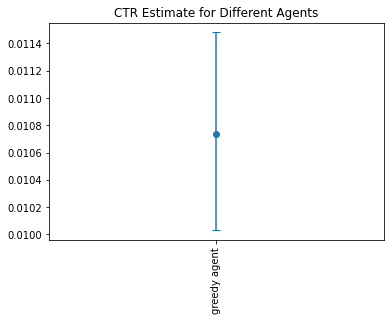

In [34]:
epsilon_greedy_args = {
    'epsilon': 0.01,
    'random_seed': np.random.randint(2 ** 31 - 1),

    # Select an Action that is ABSOLUTELY different to the Action
    # that would have been selected in case when Epsilon-Greedy Policy Selection
    # had not been applied.
    'epsilon_pure_new': True,

    # Try to select the worse case in epsilon-case.
    'epsilon_select_worse': False,
    'with_ps_all': False,
    **config
}

from recogym.agents import BanditCount

greedy_agent = EpsilonGreedy(
                Configuration(epsilon_greedy_args), 
                BanditCount(Configuration(config))
)

result = verify_agents(env, NUM_USERS, {
    'greedy agent': greedy_agent
})

fig = plot_verify_agents(result)
plt.show()

# Why isn't this really much better than pulling random levers?

Note that it's slightly better but... really not much! Ok so why is this the case? Why hasn't this improved?

# Likelihood estimates

Next let's take a look at a better clickthrough optimizer with likelihood.

The following example is much more useful because it uses a logistic regression to classify for each observation what the eventual reward would be! Is this any better??

In [35]:
class LikelihoodAgent(Agent):
    def __init__(self, feature_provider, use_argmax=False, seed=43):
        self.feature_provider = feature_provider
        self.use_argmax = use_argmax
        self.random_state = RandomState(seed)
        self.model = None
        
    @property
    def num_products(self):
        return self.feature_provider.config.num_products
    
    def _create_features(self, user_state, action):
        """Create the features that are used to estimate the expected reward from the user state.
        """
        features = np.zeros(len(user_state) * self.num_products)
        features[action * len(user_state): (action + 1) * len(user_state)] = user_state
        
        return features
    
    def train(self, logs):
        user_states, actions, rewards, proba_actions = build_rectangular_data(logs, self.feature_provider)
        
        features = np.vstack([
            self._create_features(user_state, action) 
            for user_state, action in zip(user_states, actions)
        ])
        self.model = LogisticRegression(solver='lbfgs', max_iter=5000)
        self.model.fit(features, rewards)

    
    def _score_products(self, user_state):
        all_action_features = np.array([
            self._create_features(user_state, action) 
            for action in range(self.num_products)
        ])
        return self.model.predict_proba(all_action_features)[0, :]
        
    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past history"""
        self.feature_provider.observe(observation)        
        user_state = self.feature_provider.features(observation)
        prob = self._score_products(user_state)
        
        if self.use_argmax:
            action = self.random_state.choice(self.num_products, p=prob)
            ps = prob[action]
            all_ps = prob.copy()
        else:
            action = np.argmax(prob)
            ps = 1.0
            all_ps = np.zeros(self.num_products)
            all_ps[action] = 1.0
      
        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': ps,
                'ps-a': all_ps,
            }
        }

    def reset(self):
        self.feature_provider.reset()

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 1000/1000 [00:25<00:00, 39.50it/s]


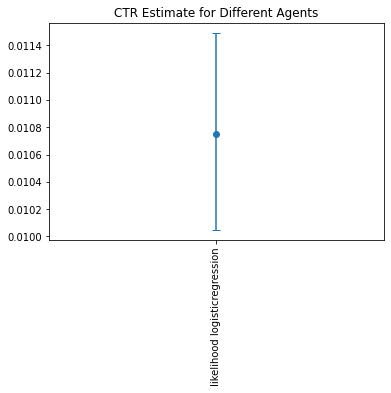

In [38]:
likelihood_logreg = LikelihoodAgent(feature_provider)
likelihood_logreg.train(popularity_policy_logs)

result = verify_agents(env, NUM_USERS, {
    'likelihood logisticregression': likelihood_logreg
})

fig = plot_verify_agents(result)
plt.show()

# Ok still not great....

Why isn't this working?

Well it comes down to ruts and popularity. In general the top 1% in popularity will keep on getting recommended even though someone has already seen it! Hrm we should take a different approach

# Contextual bandits

To figure out what to recommend to someone we need to figure out what they have seen and make better judgements based on that. Let's utilize the same underlying principle from liklihood but figure out a better way.

In [46]:
from catboost import CatBoostClassifier

class PolicyAgent(LikelihoodAgent):
    def __init__(self, feature_provider, use_argmax=False, seed=43):
        LikelihoodAgent.__init__(self, feature_provider, use_argmax=use_argmax, seed=seed)
    
    def _create_features(self, user_state, action):
        """Create the features that are used to estimate the expected reward from the user state.
        """
        return user_state
    
    def train(self, reco_log):
        user_states, actions, rewards, proba_actions = build_rectangular_data(reco_log, feature_provider)
        
        features = np.vstack([
            self._create_features(user_state, action) 
            for user_state, action in zip(user_states, actions)
        ])        
        labels = actions
        weights = rewards / proba_actions
        
        # What if you tried out something else like catboost?
#         self.model = CatBoostClassifier()
        self.model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000)        
        self.model.fit(features[weights != 0], labels[weights != 0], weights[weights != 0])
    
    def _score_products(self, user_state):
        return self.model.predict_proba(self._create_features(user_state, None).reshape(1, -1))[0, :]

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 1000/1000 [00:23<00:00, 41.85it/s]


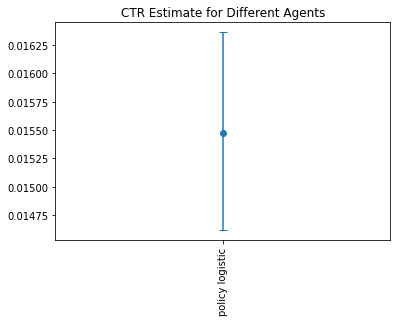

In [47]:
policy_logreg = PolicyAgent(feature_provider)
policy_logreg.train(popularity_policy_logs)

result = verify_agents(env, NUM_USERS, {
    'policy logistic': policy_logreg
})

fig = plot_verify_agents(result)
plt.show()

# Pretty good!

This is a substantial improvement over what we had before. Can we make this any better?

* What if you were to try out a different underlying model like CatBoost, or XgBoost? Would it be better?

In [84]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Input
from keras.utils import to_categorical
from keras.optimizers import Adam

class EmbeddedPolicyAgent(LikelihoodAgent):
    def __init__(self, feature_provider, use_argmax=False, seed=43):
        LikelihoodAgent.__init__(self, feature_provider, use_argmax=use_argmax, seed=seed)
    
    def _create_features(self, user_state, action):
        """Create the features that are used to estimate the expected reward from the user state.
        """
        return user_state
    
    def train(self, reco_log):
        user_states, actions, rewards, proba_actions = build_rectangular_data(reco_log, feature_provider)
        
        features = np.vstack([
            self._create_features(user_state, action) 
            for user_state, action in zip(user_states, actions)
        ])        
        labels = actions
        weights = rewards / proba_actions
        
        self.model = Sequential()

        self.model.add(Input(10))
        self.model.add(Dense(20, activation='relu'))
        self.model.add(Dense(10, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer=Adam())

        self.model.fit(
                features[weights != 0],
            to_categorical(labels[weights != 0]),
            epochs=200,
            sample_weight=weights[weights != 0])

    
    def _score_products(self, user_state):
        return self.model.predict_proba(self._create_features(user_state, None).reshape(1, -1))[0, :]

In [85]:
policy_with_embeddings = EmbeddedPolicyAgent(feature_provider)
policy_with_embeddings.train(popularity_policy_logs)

Epoch 1/200
43/43 [==============================] - 0s 927us/step - loss: 27.4248
Epoch 2/200
43/43 [==============================] - 0s 933us/step - loss: 18.3646
Epoch 3/200
43/43 [==============================] - 0s 873us/step - loss: 13.0188
Epoch 4/200
43/43 [==============================] - 0s 818us/step - loss: 10.1624
Epoch 5/200
43/43 [==============================] - 0s 860us/step - loss: 8.5306
Epoch 6/200
43/43 [==============================] - 0s 862us/step - loss: 7.6254
Epoch 7/200
43/43 [==============================] - 0s 918us/step - loss: 7.0498
Epoch 8/200
43/43 [==============================] - 0s 939us/step - loss: 6.7142
Epoch 9/200
43/43 [==============================] - 0s 914us/step - loss: 6.4811
Epoch 10/200
43/43 [==============================] - 0s 951us/step - loss: 6.3224
Epoch 11/200
43/43 [==============================] - 0s 871us/step - loss: 6.1998
Epoch 12/200
43/43 [==============================] - 0s 819us/step - loss: 6.0797
Epoch 13/

43/43 [==============================] - 0s 771us/step - loss: 4.4305
Epoch 100/200
43/43 [==============================] - 0s 768us/step - loss: 4.4067
Epoch 101/200
43/43 [==============================] - 0s 778us/step - loss: 4.4085
Epoch 102/200
43/43 [==============================] - 0s 839us/step - loss: 4.4602
Epoch 103/200
43/43 [==============================] - 0s 768us/step - loss: 4.4044
Epoch 104/200
43/43 [==============================] - 0s 758us/step - loss: 4.4341
Epoch 105/200
43/43 [==============================] - 0s 789us/step - loss: 4.3855
Epoch 106/200
43/43 [==============================] - 0s 776us/step - loss: 4.3712
Epoch 107/200
43/43 [==============================] - 0s 763us/step - loss: 4.3493
Epoch 108/200
43/43 [==============================] - 0s 843us/step - loss: 4.3393
Epoch 109/200
43/43 [==============================] - 0s 788us/step - loss: 4.3224
Epoch 110/200
43/43 [==============================] - 0s 784us/step - loss: 4.3212
Epoch 

43/43 [==============================] - 0s 752us/step - loss: 3.8787
Epoch 197/200
43/43 [==============================] - 0s 802us/step - loss: 3.8682
Epoch 198/200
43/43 [==============================] - 0s 785us/step - loss: 3.8622
Epoch 199/200
43/43 [==============================] - 0s 784us/step - loss: 3.8610
Epoch 200/200
43/43 [==============================] - 0s 785us/step - loss: 3.8604


Organic Users: 0it [00:00, ?it/s]
Users:   0%|          | 0/1000 [00:00<?, ?it/s]

Instructions for updating:
Please use `model.predict()` instead.


Users: 100%|██████████| 1000/1000 [25:21<00:00,  1.52s/it]


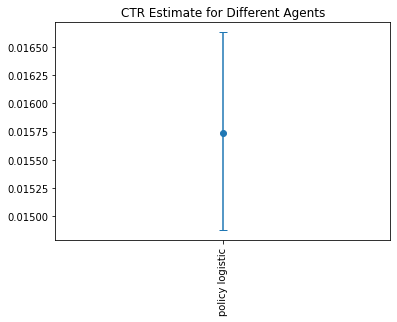

In [87]:
result = verify_agents(env, NUM_USERS, {
    'policy logistic': policy_with_embeddings
})

fig = plot_verify_agents(result)
plt.show()

# This takes wayy to long

Here's an important lesson. While we can continually add more complexity sometimes it's at the sacrifice of speed. This might actually yield better results but takes 30 minutes instead of half a minute!

What have we learned?

* What would you pick if you were to build a recommender?